In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
import catboost as ctb
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
import xgboost as xgb
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [87]:
clear = ["Opportunity_Name","ID","Last_Activity", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "ASP_converted_Currency", "Product_Name", 
         "Delivery_Year", "Month", "Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", 
         "Price", "ASP_Currency", "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type",
         "Product_Family", "Account_Name"] #"TRF"
dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date", "Last_Activity", "Actual_Delivery_Date"]
target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [88]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [89]:
def preprocess(data, ada = False):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days == 0
    data["Same_Owner"] = (data.Opportunity_Owner == data.Account_Owner) & (data.Opportunity_Owner == data.Last_Modified_By)
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    #data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    #data.loc[data.TRF == 0, "TRF_Cat"] = 0
    #data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    #data.loc[data.TRF > 7, "TRF_Cat"] = 2
    #data["Sales"] = data.groupby("Account_Name", sort=False)["Opportunity_ID"].transform(lambda x: x.nunique())
    
    data["Concrete_Offer"] = ((data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days) < 60
    #data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days    
    #data["Total_Volume"] = data.groupby("Opportunity_ID", sort = False)["Total_Amount"].transform("sum")
    data["ASP_max"] = data.groupby("Opportunity_ID", sort = False)["ASP"].transform("max")
    data["ASP_converted_max"] = data.groupby("Opportunity_ID", sort = False)["ASP_converted"].transform("max")
    data.drop(["ASP", "ASP_converted"], axis = 1, inplace = True)

    
    # fabri
    
    #data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    #data["Month"] = data.Month.str[-2:].astype(int)
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(clear + dates, axis = 1)
    
    if "Stage" in data:
        data = data[(data.Stage == "Closed Won") | (data.Stage == "Closed Lost")]
        data.Stage = data.Stage.replace({"Closed Won": 1, "Closed Lost": 0})
    
    #data.drop(data[(data.Contacts > 1) & (data.ASP.isna())].index, inplace = True)
    
    # numeric encode de categoricals
    
    if ada:    
        label_encoder = LabelEncoder()
        cat_vars = [x for x in data.select_dtypes("category").columns if x != "Stage"]
        for col in cat_vars:
            data[col] = label_encoder.fit_transform(data[col])

        # elimino nans. strategy --> mean
        #imputer = SimpleImputer(strategy = "mean")
        data.loc[data.Offer_Duration.isna(), "Offer_Duration"] = -100
        data.loc[data.Past_Quote.isna(), "Past_Quote"] = -100
        data.loc[data.Total_Amount.isna(), "Total_Amount"] = -100
        data.loc[data.Total_Volume.isna(), "Total_Volume"] = -100
        data.loc[data.ASP_max.isna(), "ASP_max"] = -100
        data.loc[data.ASP_converted_max.isna(), "ASP_converted_max"] = -100
        
        #cols = data.columns
        #data = imputer.fit_transform(data)
        #data = pd.DataFrame(data, columns = cols)

    return (data)

In [90]:
df = preprocess(data)

In [76]:
x_train, x_test, y_train, y_test = train_test_split(df, df.Stage, test_size = 0.3, random_state = 0)

In [77]:
categorical = [x for x in df.drop(target, axis = 1).select_dtypes('category').columns if x != 'Stage']
#categorical = [x for x in cat_vars if x in df.columns]
train_data = lgb.Dataset(data = x_train.drop(target, axis = 1), label = x_train.Stage, categorical_feature = categorical)
test_data =  lgb.Dataset(data = x_test.drop(target, axis = 1), label = x_test.Stage)

parameters = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boost_from_average': False,
    'is_unbalance': True,
    'boosting': 'gbdt',
    'num_leaves': 30,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.7,
    'max_depth': 7,
    'learning_rate': 0.015,
    'verbose': 0
}

model1 = lgb.train(parameters, train_data, valid_sets = test_data, num_boost_round = 5000, early_stopping_rounds = 500)

/home/eugenio/.local/lib/python2.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Account_Owner', 'Billing_Country', 'Bureaucratic_Code', 'Currency', 'Delivery_Quarter', 'Last_Modified_By', 'Opportunity_Owner', 'Source', 'Territory']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's binary_logloss: 0.685323
Training until validation scores don't improve for 500 rounds
[2]	valid_0's binary_logloss: 0.678005
[3]	valid_0's binary_logloss: 0.670577
[4]	valid_0's binary_logloss: 0.658298
[5]	valid_0's binary_logloss: 0.652035
[6]	valid_0's binary_logloss: 0.645148
[7]	valid_0's binary_logloss: 0.638498
[8]	valid_0's binary_logloss: 0.632713
[9]	valid_0's binary_logloss: 0.626694
[10]	valid_0's binary_logloss: 0.615624
[11]	valid_0's binary_logloss: 0.604851
[12]	valid_0's binary_logloss: 0.594351
[13]	valid_0's binary_logloss: 0.583991
[14]	valid_0's binary_logloss: 0.574204
[15]	valid_0's binary_logloss: 0.564326
[16]	valid_0's binary_logloss: 0.559672
[17]	valid_0's binary_logloss: 0.550528
[18]	valid_0's binary_logloss: 0.545533
[19]	valid_0's binary_logloss: 0.540859
[20]	valid_0's binary_logloss: 0.536106
[21]	valid_0's binary_logloss: 0.527452
[22]	valid_0's binary_logloss: 0.518968
[23]	valid_0's binary_logloss: 0.514411
[24]	valid_0's binary_loglo

[227]	valid_0's binary_logloss: 0.123757
[228]	valid_0's binary_logloss: 0.123496
[229]	valid_0's binary_logloss: 0.123293
[230]	valid_0's binary_logloss: 0.123031
[231]	valid_0's binary_logloss: 0.122863
[232]	valid_0's binary_logloss: 0.122262
[233]	valid_0's binary_logloss: 0.122055
[234]	valid_0's binary_logloss: 0.121872
[235]	valid_0's binary_logloss: 0.121617
[236]	valid_0's binary_logloss: 0.121436
[237]	valid_0's binary_logloss: 0.121207
[238]	valid_0's binary_logloss: 0.120563
[239]	valid_0's binary_logloss: 0.120337
[240]	valid_0's binary_logloss: 0.12019
[241]	valid_0's binary_logloss: 0.119549
[242]	valid_0's binary_logloss: 0.118928
[243]	valid_0's binary_logloss: 0.118352
[244]	valid_0's binary_logloss: 0.117794
[245]	valid_0's binary_logloss: 0.117298
[246]	valid_0's binary_logloss: 0.116811
[247]	valid_0's binary_logloss: 0.116687
[248]	valid_0's binary_logloss: 0.116461
[249]	valid_0's binary_logloss: 0.116269
[250]	valid_0's binary_logloss: 0.116092
[251]	valid_0's b

[427]	valid_0's binary_logloss: 0.0825719
[428]	valid_0's binary_logloss: 0.0824073
[429]	valid_0's binary_logloss: 0.0823088
[430]	valid_0's binary_logloss: 0.0821784
[431]	valid_0's binary_logloss: 0.0820604
[432]	valid_0's binary_logloss: 0.0819974
[433]	valid_0's binary_logloss: 0.0819361
[434]	valid_0's binary_logloss: 0.0818684
[435]	valid_0's binary_logloss: 0.0818118
[436]	valid_0's binary_logloss: 0.0817502
[437]	valid_0's binary_logloss: 0.0816577
[438]	valid_0's binary_logloss: 0.081607
[439]	valid_0's binary_logloss: 0.0814775
[440]	valid_0's binary_logloss: 0.0813262
[441]	valid_0's binary_logloss: 0.081311
[442]	valid_0's binary_logloss: 0.0812152
[443]	valid_0's binary_logloss: 0.0810841
[444]	valid_0's binary_logloss: 0.0809568
[445]	valid_0's binary_logloss: 0.0807945
[446]	valid_0's binary_logloss: 0.0807759
[447]	valid_0's binary_logloss: 0.080744
[448]	valid_0's binary_logloss: 0.0806097
[449]	valid_0's binary_logloss: 0.0805117
[450]	valid_0's binary_logloss: 0.080

[638]	valid_0's binary_logloss: 0.0690506
[639]	valid_0's binary_logloss: 0.0690089
[640]	valid_0's binary_logloss: 0.0689599
[641]	valid_0's binary_logloss: 0.0689298
[642]	valid_0's binary_logloss: 0.0689102
[643]	valid_0's binary_logloss: 0.0688695
[644]	valid_0's binary_logloss: 0.0688454
[645]	valid_0's binary_logloss: 0.0688096
[646]	valid_0's binary_logloss: 0.068787
[647]	valid_0's binary_logloss: 0.0687522
[648]	valid_0's binary_logloss: 0.068709
[649]	valid_0's binary_logloss: 0.0686515
[650]	valid_0's binary_logloss: 0.068635
[651]	valid_0's binary_logloss: 0.0686094
[652]	valid_0's binary_logloss: 0.0685665
[653]	valid_0's binary_logloss: 0.0685519
[654]	valid_0's binary_logloss: 0.0685211
[655]	valid_0's binary_logloss: 0.0684751
[656]	valid_0's binary_logloss: 0.0684358
[657]	valid_0's binary_logloss: 0.0683866
[658]	valid_0's binary_logloss: 0.0683195
[659]	valid_0's binary_logloss: 0.0682659
[660]	valid_0's binary_logloss: 0.0682444
[661]	valid_0's binary_logloss: 0.068

[847]	valid_0's binary_logloss: 0.0642607
[848]	valid_0's binary_logloss: 0.0642483
[849]	valid_0's binary_logloss: 0.0642142
[850]	valid_0's binary_logloss: 0.0642189
[851]	valid_0's binary_logloss: 0.064184
[852]	valid_0's binary_logloss: 0.064183
[853]	valid_0's binary_logloss: 0.0641826
[854]	valid_0's binary_logloss: 0.0641683
[855]	valid_0's binary_logloss: 0.0641437
[856]	valid_0's binary_logloss: 0.0641174
[857]	valid_0's binary_logloss: 0.0640837
[858]	valid_0's binary_logloss: 0.0640719
[859]	valid_0's binary_logloss: 0.064072
[860]	valid_0's binary_logloss: 0.0640235
[861]	valid_0's binary_logloss: 0.0639985
[862]	valid_0's binary_logloss: 0.0639897
[863]	valid_0's binary_logloss: 0.0639762
[864]	valid_0's binary_logloss: 0.0639173
[865]	valid_0's binary_logloss: 0.0638941
[866]	valid_0's binary_logloss: 0.0638619
[867]	valid_0's binary_logloss: 0.0638448
[868]	valid_0's binary_logloss: 0.0638416
[869]	valid_0's binary_logloss: 0.0638421
[870]	valid_0's binary_logloss: 0.063

[1088]	valid_0's binary_logloss: 0.0617355
[1089]	valid_0's binary_logloss: 0.061731
[1090]	valid_0's binary_logloss: 0.0617288
[1091]	valid_0's binary_logloss: 0.0617478
[1092]	valid_0's binary_logloss: 0.0617511
[1093]	valid_0's binary_logloss: 0.0617465
[1094]	valid_0's binary_logloss: 0.0617542
[1095]	valid_0's binary_logloss: 0.061741
[1096]	valid_0's binary_logloss: 0.0617402
[1097]	valid_0's binary_logloss: 0.0617583
[1098]	valid_0's binary_logloss: 0.0617563
[1099]	valid_0's binary_logloss: 0.061783
[1100]	valid_0's binary_logloss: 0.0617959
[1101]	valid_0's binary_logloss: 0.0617957
[1102]	valid_0's binary_logloss: 0.0617966
[1103]	valid_0's binary_logloss: 0.0617994
[1104]	valid_0's binary_logloss: 0.0617762
[1105]	valid_0's binary_logloss: 0.0617725
[1106]	valid_0's binary_logloss: 0.0617563
[1107]	valid_0's binary_logloss: 0.061759
[1108]	valid_0's binary_logloss: 0.061755
[1109]	valid_0's binary_logloss: 0.0617656
[1110]	valid_0's binary_logloss: 0.0617654
[1111]	valid_0's

[1323]	valid_0's binary_logloss: 0.0619336
[1324]	valid_0's binary_logloss: 0.0619526
[1325]	valid_0's binary_logloss: 0.061942
[1326]	valid_0's binary_logloss: 0.0619517
[1327]	valid_0's binary_logloss: 0.0619564
[1328]	valid_0's binary_logloss: 0.061957
[1329]	valid_0's binary_logloss: 0.0619742
[1330]	valid_0's binary_logloss: 0.0619672
[1331]	valid_0's binary_logloss: 0.0619592
[1332]	valid_0's binary_logloss: 0.0619583
[1333]	valid_0's binary_logloss: 0.0619415
[1334]	valid_0's binary_logloss: 0.0619572
[1335]	valid_0's binary_logloss: 0.0619744
[1336]	valid_0's binary_logloss: 0.0619867
[1337]	valid_0's binary_logloss: 0.0620047
[1338]	valid_0's binary_logloss: 0.0620017
[1339]	valid_0's binary_logloss: 0.0620029
[1340]	valid_0's binary_logloss: 0.0619802
[1341]	valid_0's binary_logloss: 0.062
[1342]	valid_0's binary_logloss: 0.0619974
[1343]	valid_0's binary_logloss: 0.0619925
[1344]	valid_0's binary_logloss: 0.0620003
[1345]	valid_0's binary_logloss: 0.0620032
[1346]	valid_0's 

[1571]	valid_0's binary_logloss: 0.0627228
[1572]	valid_0's binary_logloss: 0.0627316
[1573]	valid_0's binary_logloss: 0.0627452
[1574]	valid_0's binary_logloss: 0.0627686
[1575]	valid_0's binary_logloss: 0.0627769
[1576]	valid_0's binary_logloss: 0.0627975
[1577]	valid_0's binary_logloss: 0.062815
[1578]	valid_0's binary_logloss: 0.0628239
[1579]	valid_0's binary_logloss: 0.0628277
[1580]	valid_0's binary_logloss: 0.0628488
[1581]	valid_0's binary_logloss: 0.0628336
[1582]	valid_0's binary_logloss: 0.0628564
[1583]	valid_0's binary_logloss: 0.062856
[1584]	valid_0's binary_logloss: 0.0628543
[1585]	valid_0's binary_logloss: 0.0628371
[1586]	valid_0's binary_logloss: 0.0628488
[1587]	valid_0's binary_logloss: 0.0628658
[1588]	valid_0's binary_logloss: 0.0628757
[1589]	valid_0's binary_logloss: 0.0628871
[1590]	valid_0's binary_logloss: 0.0628662
[1591]	valid_0's binary_logloss: 0.0628722
[1592]	valid_0's binary_logloss: 0.0628892
[1593]	valid_0's binary_logloss: 0.0629041
[1594]	valid_

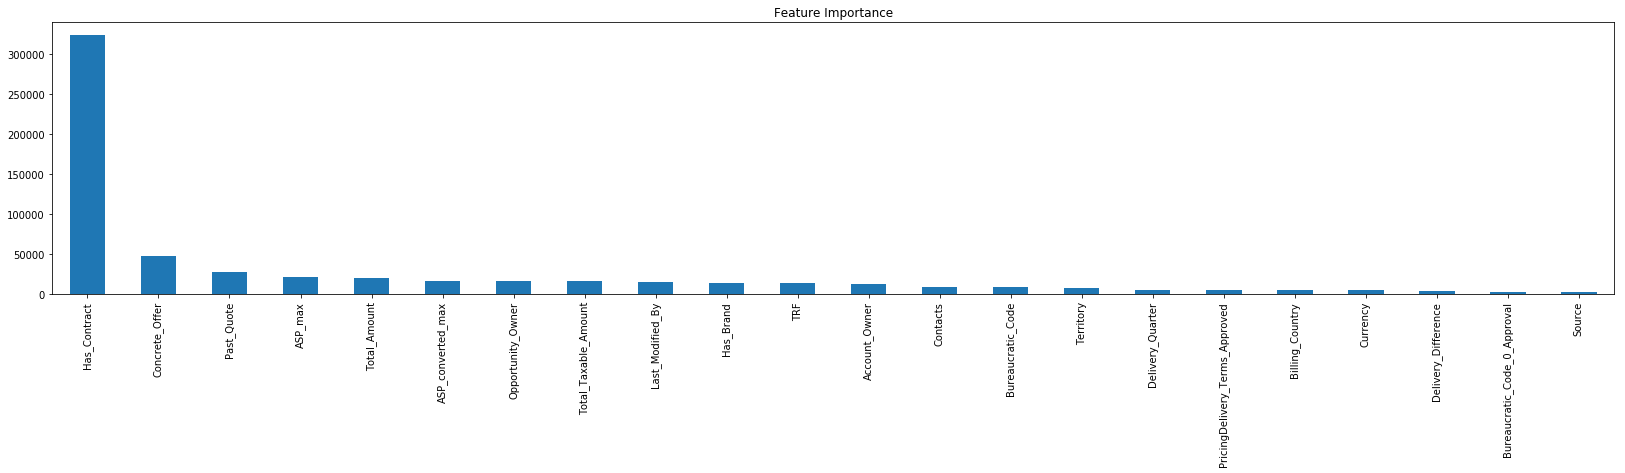

In [78]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model1.feature_importance("gain"), predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind='bar', title='Feature Importance')

In [79]:
print feat_imp

Has_Contract                      323706.166003
Concrete_Offer                     47778.681402
Past_Quote                         27172.545072
ASP_max                            21919.495646
Total_Amount                       20208.253487
ASP_converted_max                  16719.113860
Opportunity_Owner                  16710.343475
Total_Taxable_Amount               15829.281307
Last_Modified_By                   14879.803822
Has_Brand                          14102.084460
TRF                                13765.722384
Account_Owner                      13052.736143
Contacts                            9303.415112
Bureaucratic_Code                   8652.141174
Territory                           7296.509279
Delivery_Quarter                    5527.777470
PricingDelivery_Terms_Approved      5367.335022
Billing_Country                     5113.132693
Currency                            4799.704501
Delivery_Difference                 3564.815430
Bureaucratic_Code_0_Approval        3023

In [80]:
pred = model1.predict(x_test.drop(target, axis = 1))
pred = pd.DataFrame(pred, index = x_test.index, columns = ["Prediction"])
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [81]:
log_loss(answer["Stage"], answer["Prediction"])

0.07051643840141049

In [8]:
model0 = lgb.LGBMClassifier(n_estimators = 1000,
                            learning_rate = 0.015,
                            colsample_bytree = 0.5,
                            objective = "binary",
                            max_depth = 7, 
                            eval_metric = 'Logloss',
                            random_state = 42)

In [9]:
model0.fit(x_train.drop(target, axis = 1), y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
        eval_metric='Logloss', importance_type='split',
        learning_rate=0.015, max_depth=7, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
        n_jobs=-1, num_leaves=31, objective='binary', random_state=42,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [10]:
y_pred = model0.predict_proba(x_test.drop(target, axis = 1))[:,1]

In [11]:
log_loss(y_test, y_pred)

0.07507718536639109

In [82]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model1.predict(validation.drop(leak, axis = 1))

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
val_booster = validation.join(pred)

answer = pd.DataFrame(val_booster.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [83]:
prev = pd.read_csv("acceptable/submission_11.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.980505985513549

In [84]:
prev = pd.read_csv("acceptable/submission_23.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9744790736148025

In [85]:
prev = pd.read_csv("submisson_ensamble_6.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9776296339493745

In [25]:
answer

,Opportunity_ID,Prediction
0,10689,0.999220
1,10690,0.995739
2,10691,0.958307
3,10692,0.695015
4,10693,0.991782
5,10694,0.991917
6,10695,0.000865
7,10696,0.000965
8,10697,0.003732
9,10698,0.001549


In [86]:
answer.to_csv("lgb_intento.csv", index = False, header = False)

In [20]:
pred = model0.predict_proba(validation.drop(leak, axis = 1))[:,1]

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
val_classi = validation.join(pred)

answer = pd.DataFrame(val_classi.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [31]:
FOLDS = 3
kf = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state = 0)
pred_full = 0
cv_score = []
i = 1
X = df.drop(target, axis = 1)
y = df.Stage
model_list = []

for train_index,test_index in kf.split(X, y):
    
    print('{} of KFold {}'.format(i, kf.n_splits))
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    train_data = lgb.Dataset(data = x_train, label = y_train, categorical_feature = categorical)
    test_data =  lgb.Dataset(data = x_test, label = y_test)

    parameters = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boost_from_average': False,
        'is_unbalance': True,
        'boosting': 'gbdt',
        'num_leaves': 30,
        'feature_fraction': 0.5,
        'bagging_fraction': 0.5,
        'bagging_freq': 20,
        'max_depth': 7,
        'learning_rate': 0.01,
        'verbose': 0
    }
    
    model = lgb.train(parameters, train_data, 
                      valid_sets = test_data, 
                      num_boost_round = 2000,
                      early_stopping_rounds = 200)
    
    model_list += [model]
    score = log_loss(y_test, model.predict(x_test))
    print('LOG LOSS score:', score)
    cv_score.append(score)
    pred = model.predict(validation.drop(leak, axis = 1))
    pred_full += pred
    i += 1
pred_full /= FOLDS

1 of KFold 3
[1]	valid_0's binary_logloss: 0.684639
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.676369
[3]	valid_0's binary_logloss: 0.672058
[4]	valid_0's binary_logloss: 0.664009
[5]	valid_0's binary_logloss: 0.659467
[6]	valid_0's binary_logloss: 0.655256
[7]	valid_0's binary_logloss: 0.647529
[8]	valid_0's binary_logloss: 0.643863
[9]	valid_0's binary_logloss: 0.639802
[10]	valid_0's binary_logloss: 0.632317
[11]	valid_0's binary_logloss: 0.628988
[12]	valid_0's binary_logloss: 0.625211
[13]	valid_0's binary_logloss: 0.618068
[14]	valid_0's binary_logloss: 0.611025
[15]	valid_0's binary_logloss: 0.604114
[16]	valid_0's binary_logloss: 0.59727
[17]	valid_0's binary_logloss: 0.590645
[18]	valid_0's binary_logloss: 0.587407
[19]	valid_0's binary_logloss: 0.584231
[20]	valid_0's binary_logloss: 0.580776
[21]	valid_0's binary_logloss: 0.574398
[22]	valid_0's binary_logloss: 0.568114
[23]	valid_0's binary_logloss: 0.564888
[24]	valid_0's 

[246]	valid_0's binary_logloss: 0.18449
[247]	valid_0's binary_logloss: 0.184191
[248]	valid_0's binary_logloss: 0.183876
[249]	valid_0's binary_logloss: 0.183632
[250]	valid_0's binary_logloss: 0.182729
[251]	valid_0's binary_logloss: 0.182459
[252]	valid_0's binary_logloss: 0.182241
[253]	valid_0's binary_logloss: 0.181363
[254]	valid_0's binary_logloss: 0.181153
[255]	valid_0's binary_logloss: 0.180866
[256]	valid_0's binary_logloss: 0.179963
[257]	valid_0's binary_logloss: 0.179746
[258]	valid_0's binary_logloss: 0.178931
[259]	valid_0's binary_logloss: 0.178029
[260]	valid_0's binary_logloss: 0.177824
[261]	valid_0's binary_logloss: 0.177563
[262]	valid_0's binary_logloss: 0.177287
[263]	valid_0's binary_logloss: 0.176435
[264]	valid_0's binary_logloss: 0.175591
[265]	valid_0's binary_logloss: 0.175365
[266]	valid_0's binary_logloss: 0.174511
[267]	valid_0's binary_logloss: 0.174339
[268]	valid_0's binary_logloss: 0.174179
[269]	valid_0's binary_logloss: 0.173327
[270]	valid_0's b

[464]	valid_0's binary_logloss: 0.117765
[465]	valid_0's binary_logloss: 0.117686
[466]	valid_0's binary_logloss: 0.117577
[467]	valid_0's binary_logloss: 0.117373
[468]	valid_0's binary_logloss: 0.117169
[469]	valid_0's binary_logloss: 0.117079
[470]	valid_0's binary_logloss: 0.116863
[471]	valid_0's binary_logloss: 0.116768
[472]	valid_0's binary_logloss: 0.116504
[473]	valid_0's binary_logloss: 0.116413
[474]	valid_0's binary_logloss: 0.116206
[475]	valid_0's binary_logloss: 0.116019
[476]	valid_0's binary_logloss: 0.115806
[477]	valid_0's binary_logloss: 0.115592
[478]	valid_0's binary_logloss: 0.115505
[479]	valid_0's binary_logloss: 0.115314
[480]	valid_0's binary_logloss: 0.115224
[481]	valid_0's binary_logloss: 0.115011
[482]	valid_0's binary_logloss: 0.114944
[483]	valid_0's binary_logloss: 0.114849
[484]	valid_0's binary_logloss: 0.114644
[485]	valid_0's binary_logloss: 0.114587
[486]	valid_0's binary_logloss: 0.114369
[487]	valid_0's binary_logloss: 0.114156
[488]	valid_0's 

[720]	valid_0's binary_logloss: 0.0969748
[721]	valid_0's binary_logloss: 0.0968977
[722]	valid_0's binary_logloss: 0.0968544
[723]	valid_0's binary_logloss: 0.0968201
[724]	valid_0's binary_logloss: 0.0967516
[725]	valid_0's binary_logloss: 0.0967179
[726]	valid_0's binary_logloss: 0.0966665
[727]	valid_0's binary_logloss: 0.0966709
[728]	valid_0's binary_logloss: 0.0966357
[729]	valid_0's binary_logloss: 0.0966024
[730]	valid_0's binary_logloss: 0.096585
[731]	valid_0's binary_logloss: 0.0965434
[732]	valid_0's binary_logloss: 0.0965439
[733]	valid_0's binary_logloss: 0.0964978
[734]	valid_0's binary_logloss: 0.0964912
[735]	valid_0's binary_logloss: 0.0964322
[736]	valid_0's binary_logloss: 0.096362
[737]	valid_0's binary_logloss: 0.096365
[738]	valid_0's binary_logloss: 0.096313
[739]	valid_0's binary_logloss: 0.096226
[740]	valid_0's binary_logloss: 0.0962018
[741]	valid_0's binary_logloss: 0.0962041
[742]	valid_0's binary_logloss: 0.0961476
[743]	valid_0's binary_logloss: 0.09610

[961]	valid_0's binary_logloss: 0.0916719
[962]	valid_0's binary_logloss: 0.0916445
[963]	valid_0's binary_logloss: 0.0916363
[964]	valid_0's binary_logloss: 0.0916297
[965]	valid_0's binary_logloss: 0.0916173
[966]	valid_0's binary_logloss: 0.0916012
[967]	valid_0's binary_logloss: 0.0916041
[968]	valid_0's binary_logloss: 0.0915858
[969]	valid_0's binary_logloss: 0.0915605
[970]	valid_0's binary_logloss: 0.0915649
[971]	valid_0's binary_logloss: 0.0915155
[972]	valid_0's binary_logloss: 0.0915211
[973]	valid_0's binary_logloss: 0.0914979
[974]	valid_0's binary_logloss: 0.0914646
[975]	valid_0's binary_logloss: 0.09144
[976]	valid_0's binary_logloss: 0.0914158
[977]	valid_0's binary_logloss: 0.0914055
[978]	valid_0's binary_logloss: 0.0913878
[979]	valid_0's binary_logloss: 0.0913784
[980]	valid_0's binary_logloss: 0.0913867
[981]	valid_0's binary_logloss: 0.0913514
[982]	valid_0's binary_logloss: 0.0913565
[983]	valid_0's binary_logloss: 0.09137
[984]	valid_0's binary_logloss: 0.0913

[1186]	valid_0's binary_logloss: 0.0898955
[1187]	valid_0's binary_logloss: 0.0898589
[1188]	valid_0's binary_logloss: 0.0898332
[1189]	valid_0's binary_logloss: 0.0897993
[1190]	valid_0's binary_logloss: 0.0898134
[1191]	valid_0's binary_logloss: 0.08982
[1192]	valid_0's binary_logloss: 0.0898171
[1193]	valid_0's binary_logloss: 0.0897917
[1194]	valid_0's binary_logloss: 0.0897593
[1195]	valid_0's binary_logloss: 0.0897486
[1196]	valid_0's binary_logloss: 0.0897274
[1197]	valid_0's binary_logloss: 0.0897042
[1198]	valid_0's binary_logloss: 0.0897104
[1199]	valid_0's binary_logloss: 0.0897091
[1200]	valid_0's binary_logloss: 0.0897068
[1201]	valid_0's binary_logloss: 0.0897001
[1202]	valid_0's binary_logloss: 0.0896922
[1203]	valid_0's binary_logloss: 0.0896894
[1204]	valid_0's binary_logloss: 0.0896672
[1205]	valid_0's binary_logloss: 0.0896837
[1206]	valid_0's binary_logloss: 0.0896995
[1207]	valid_0's binary_logloss: 0.0897065
[1208]	valid_0's binary_logloss: 0.0897158
[1209]	valid_

[1416]	valid_0's binary_logloss: 0.0901218
[1417]	valid_0's binary_logloss: 0.090109
[1418]	valid_0's binary_logloss: 0.0901269
[1419]	valid_0's binary_logloss: 0.090177
[1420]	valid_0's binary_logloss: 0.0901618
[1421]	valid_0's binary_logloss: 0.0901253
[1422]	valid_0's binary_logloss: 0.0901093
[1423]	valid_0's binary_logloss: 0.0901108
[1424]	valid_0's binary_logloss: 0.090094
[1425]	valid_0's binary_logloss: 0.0900933
[1426]	valid_0's binary_logloss: 0.0900897
[1427]	valid_0's binary_logloss: 0.0900856
[1428]	valid_0's binary_logloss: 0.0900804
[1429]	valid_0's binary_logloss: 0.0901121
[1430]	valid_0's binary_logloss: 0.0901311
[1431]	valid_0's binary_logloss: 0.0901687
[1432]	valid_0's binary_logloss: 0.0901963
[1433]	valid_0's binary_logloss: 0.090203
[1434]	valid_0's binary_logloss: 0.0901886
[1435]	valid_0's binary_logloss: 0.0901871
[1436]	valid_0's binary_logloss: 0.0901911
[1437]	valid_0's binary_logloss: 0.0902076
[1438]	valid_0's binary_logloss: 0.0902203
[1439]	valid_0'

[221]	valid_0's binary_logloss: 0.197566
[222]	valid_0's binary_logloss: 0.197236
[223]	valid_0's binary_logloss: 0.196078
[224]	valid_0's binary_logloss: 0.194986
[225]	valid_0's binary_logloss: 0.193865
[226]	valid_0's binary_logloss: 0.192725
[227]	valid_0's binary_logloss: 0.191577
[228]	valid_0's binary_logloss: 0.190483
[229]	valid_0's binary_logloss: 0.190142
[230]	valid_0's binary_logloss: 0.189774
[231]	valid_0's binary_logloss: 0.189419
[232]	valid_0's binary_logloss: 0.189098
[233]	valid_0's binary_logloss: 0.188796
[234]	valid_0's binary_logloss: 0.188484
[235]	valid_0's binary_logloss: 0.187457
[236]	valid_0's binary_logloss: 0.186436
[237]	valid_0's binary_logloss: 0.186144
[238]	valid_0's binary_logloss: 0.185039
[239]	valid_0's binary_logloss: 0.184031
[240]	valid_0's binary_logloss: 0.183032
[241]	valid_0's binary_logloss: 0.182008
[242]	valid_0's binary_logloss: 0.181745
[243]	valid_0's binary_logloss: 0.181488
[244]	valid_0's binary_logloss: 0.18056
[245]	valid_0's b

[477]	valid_0's binary_logloss: 0.105902
[478]	valid_0's binary_logloss: 0.105834
[479]	valid_0's binary_logloss: 0.105601
[480]	valid_0's binary_logloss: 0.105509
[481]	valid_0's binary_logloss: 0.105312
[482]	valid_0's binary_logloss: 0.105221
[483]	valid_0's binary_logloss: 0.105194
[484]	valid_0's binary_logloss: 0.104943
[485]	valid_0's binary_logloss: 0.104856
[486]	valid_0's binary_logloss: 0.104641
[487]	valid_0's binary_logloss: 0.104443
[488]	valid_0's binary_logloss: 0.104369
[489]	valid_0's binary_logloss: 0.104298
[490]	valid_0's binary_logloss: 0.104079
[491]	valid_0's binary_logloss: 0.103987
[492]	valid_0's binary_logloss: 0.103803
[493]	valid_0's binary_logloss: 0.103594
[494]	valid_0's binary_logloss: 0.103533
[495]	valid_0's binary_logloss: 0.10346
[496]	valid_0's binary_logloss: 0.103211
[497]	valid_0's binary_logloss: 0.103007
[498]	valid_0's binary_logloss: 0.102796
[499]	valid_0's binary_logloss: 0.102737
[500]	valid_0's binary_logloss: 0.102657
[501]	valid_0's b

[719]	valid_0's binary_logloss: 0.0840372
[720]	valid_0's binary_logloss: 0.0839935
[721]	valid_0's binary_logloss: 0.083923
[722]	valid_0's binary_logloss: 0.0838712
[723]	valid_0's binary_logloss: 0.0837997
[724]	valid_0's binary_logloss: 0.0837437
[725]	valid_0's binary_logloss: 0.0837365
[726]	valid_0's binary_logloss: 0.0836793
[727]	valid_0's binary_logloss: 0.0836349
[728]	valid_0's binary_logloss: 0.0836041
[729]	valid_0's binary_logloss: 0.0836009
[730]	valid_0's binary_logloss: 0.0835571
[731]	valid_0's binary_logloss: 0.0835006
[732]	valid_0's binary_logloss: 0.0834648
[733]	valid_0's binary_logloss: 0.08343
[734]	valid_0's binary_logloss: 0.0834123
[735]	valid_0's binary_logloss: 0.0833498
[736]	valid_0's binary_logloss: 0.0833238
[737]	valid_0's binary_logloss: 0.0833136
[738]	valid_0's binary_logloss: 0.0832465
[739]	valid_0's binary_logloss: 0.0831654
[740]	valid_0's binary_logloss: 0.0831448
[741]	valid_0's binary_logloss: 0.0830931
[742]	valid_0's binary_logloss: 0.083

[964]	valid_0's binary_logloss: 0.0760266
[965]	valid_0's binary_logloss: 0.0760022
[966]	valid_0's binary_logloss: 0.0759829
[967]	valid_0's binary_logloss: 0.0759593
[968]	valid_0's binary_logloss: 0.0759414
[969]	valid_0's binary_logloss: 0.0759149
[970]	valid_0's binary_logloss: 0.0758901
[971]	valid_0's binary_logloss: 0.0758782
[972]	valid_0's binary_logloss: 0.0758674
[973]	valid_0's binary_logloss: 0.0758592
[974]	valid_0's binary_logloss: 0.0758363
[975]	valid_0's binary_logloss: 0.0758198
[976]	valid_0's binary_logloss: 0.0757973
[977]	valid_0's binary_logloss: 0.0757767
[978]	valid_0's binary_logloss: 0.0757752
[979]	valid_0's binary_logloss: 0.0757552
[980]	valid_0's binary_logloss: 0.075722
[981]	valid_0's binary_logloss: 0.0757077
[982]	valid_0's binary_logloss: 0.0757019
[983]	valid_0's binary_logloss: 0.0756923
[984]	valid_0's binary_logloss: 0.0756656
[985]	valid_0's binary_logloss: 0.0756574
[986]	valid_0's binary_logloss: 0.0756331
[987]	valid_0's binary_logloss: 0.0

[1203]	valid_0's binary_logloss: 0.07081
[1204]	valid_0's binary_logloss: 0.0708197
[1205]	valid_0's binary_logloss: 0.0708331
[1206]	valid_0's binary_logloss: 0.0708245
[1207]	valid_0's binary_logloss: 0.0708412
[1208]	valid_0's binary_logloss: 0.0708223
[1209]	valid_0's binary_logloss: 0.0708311
[1210]	valid_0's binary_logloss: 0.0708062
[1211]	valid_0's binary_logloss: 0.070814
[1212]	valid_0's binary_logloss: 0.0708237
[1213]	valid_0's binary_logloss: 0.0708327
[1214]	valid_0's binary_logloss: 0.0708273
[1215]	valid_0's binary_logloss: 0.0708336
[1216]	valid_0's binary_logloss: 0.0708506
[1217]	valid_0's binary_logloss: 0.0708467
[1218]	valid_0's binary_logloss: 0.0708477
[1219]	valid_0's binary_logloss: 0.0708614
[1220]	valid_0's binary_logloss: 0.0708944
[1221]	valid_0's binary_logloss: 0.0709062
[1222]	valid_0's binary_logloss: 0.0708911
[1223]	valid_0's binary_logloss: 0.0708687
[1224]	valid_0's binary_logloss: 0.0708466
[1225]	valid_0's binary_logloss: 0.0708494
[1226]	valid_0

[1444]	valid_0's binary_logloss: 0.0696794
[1445]	valid_0's binary_logloss: 0.0696511
[1446]	valid_0's binary_logloss: 0.0696411
[1447]	valid_0's binary_logloss: 0.0696159
[1448]	valid_0's binary_logloss: 0.0696288
[1449]	valid_0's binary_logloss: 0.0696125
[1450]	valid_0's binary_logloss: 0.0695992
[1451]	valid_0's binary_logloss: 0.0695848
[1452]	valid_0's binary_logloss: 0.069584
[1453]	valid_0's binary_logloss: 0.0695687
[1454]	valid_0's binary_logloss: 0.0695439
[1455]	valid_0's binary_logloss: 0.0695304
[1456]	valid_0's binary_logloss: 0.0695224
[1457]	valid_0's binary_logloss: 0.069522
[1458]	valid_0's binary_logloss: 0.0695052
[1459]	valid_0's binary_logloss: 0.069491
[1460]	valid_0's binary_logloss: 0.069476
[1461]	valid_0's binary_logloss: 0.0694621
[1462]	valid_0's binary_logloss: 0.0694631
[1463]	valid_0's binary_logloss: 0.0694495
[1464]	valid_0's binary_logloss: 0.0694502
[1465]	valid_0's binary_logloss: 0.0694346
[1466]	valid_0's binary_logloss: 0.0694451
[1467]	valid_0'

[1677]	valid_0's binary_logloss: 0.0680028
[1678]	valid_0's binary_logloss: 0.0680146
[1679]	valid_0's binary_logloss: 0.0679991
[1680]	valid_0's binary_logloss: 0.0680023
[1681]	valid_0's binary_logloss: 0.068018
[1682]	valid_0's binary_logloss: 0.068032
[1683]	valid_0's binary_logloss: 0.0680216
[1684]	valid_0's binary_logloss: 0.068043
[1685]	valid_0's binary_logloss: 0.0680421
[1686]	valid_0's binary_logloss: 0.0680385
[1687]	valid_0's binary_logloss: 0.0680562
[1688]	valid_0's binary_logloss: 0.0680654
[1689]	valid_0's binary_logloss: 0.0680633
[1690]	valid_0's binary_logloss: 0.0680917
[1691]	valid_0's binary_logloss: 0.0681177
[1692]	valid_0's binary_logloss: 0.0681274
[1693]	valid_0's binary_logloss: 0.0681215
[1694]	valid_0's binary_logloss: 0.0681445
[1695]	valid_0's binary_logloss: 0.0681567
[1696]	valid_0's binary_logloss: 0.0681631
[1697]	valid_0's binary_logloss: 0.0681663
[1698]	valid_0's binary_logloss: 0.0681779
[1699]	valid_0's binary_logloss: 0.0681962
[1700]	valid_0

[1908]	valid_0's binary_logloss: 0.0678859
[1909]	valid_0's binary_logloss: 0.067902
[1910]	valid_0's binary_logloss: 0.0679027
[1911]	valid_0's binary_logloss: 0.0679055
[1912]	valid_0's binary_logloss: 0.0679094
[1913]	valid_0's binary_logloss: 0.0679143
[1914]	valid_0's binary_logloss: 0.0679095
[1915]	valid_0's binary_logloss: 0.0679061
[1916]	valid_0's binary_logloss: 0.0678999
[1917]	valid_0's binary_logloss: 0.0678957
[1918]	valid_0's binary_logloss: 0.067914
[1919]	valid_0's binary_logloss: 0.0679261
[1920]	valid_0's binary_logloss: 0.0679294
[1921]	valid_0's binary_logloss: 0.0679307
[1922]	valid_0's binary_logloss: 0.0679391
[1923]	valid_0's binary_logloss: 0.0679562
[1924]	valid_0's binary_logloss: 0.0679731
[1925]	valid_0's binary_logloss: 0.068006
[1926]	valid_0's binary_logloss: 0.0680263
[1927]	valid_0's binary_logloss: 0.0680365
[1928]	valid_0's binary_logloss: 0.0680374
[1929]	valid_0's binary_logloss: 0.0680594
[1930]	valid_0's binary_logloss: 0.0680668
[1931]	valid_0

[153]	valid_0's binary_logloss: 0.259981
[154]	valid_0's binary_logloss: 0.258081
[155]	valid_0's binary_logloss: 0.25754
[156]	valid_0's binary_logloss: 0.255711
[157]	valid_0's binary_logloss: 0.253891
[158]	valid_0's binary_logloss: 0.252155
[159]	valid_0's binary_logloss: 0.25155
[160]	valid_0's binary_logloss: 0.251031
[161]	valid_0's binary_logloss: 0.250435
[162]	valid_0's binary_logloss: 0.24995
[163]	valid_0's binary_logloss: 0.249457
[164]	valid_0's binary_logloss: 0.248915
[165]	valid_0's binary_logloss: 0.248337
[166]	valid_0's binary_logloss: 0.247785
[167]	valid_0's binary_logloss: 0.247184
[168]	valid_0's binary_logloss: 0.245558
[169]	valid_0's binary_logloss: 0.243911
[170]	valid_0's binary_logloss: 0.243432
[171]	valid_0's binary_logloss: 0.24181
[172]	valid_0's binary_logloss: 0.241321
[173]	valid_0's binary_logloss: 0.240808
[174]	valid_0's binary_logloss: 0.24027
[175]	valid_0's binary_logloss: 0.23973
[176]	valid_0's binary_logloss: 0.238133
[177]	valid_0's binary

[406]	valid_0's binary_logloss: 0.120782
[407]	valid_0's binary_logloss: 0.120657
[408]	valid_0's binary_logloss: 0.120314
[409]	valid_0's binary_logloss: 0.119914
[410]	valid_0's binary_logloss: 0.119582
[411]	valid_0's binary_logloss: 0.11923
[412]	valid_0's binary_logloss: 0.118908
[413]	valid_0's binary_logloss: 0.118578
[414]	valid_0's binary_logloss: 0.118501
[415]	valid_0's binary_logloss: 0.118421
[416]	valid_0's binary_logloss: 0.118333
[417]	valid_0's binary_logloss: 0.118032
[418]	valid_0's binary_logloss: 0.117934
[419]	valid_0's binary_logloss: 0.117606
[420]	valid_0's binary_logloss: 0.11748
[421]	valid_0's binary_logloss: 0.117398
[422]	valid_0's binary_logloss: 0.117331
[423]	valid_0's binary_logloss: 0.117261
[424]	valid_0's binary_logloss: 0.117186
[425]	valid_0's binary_logloss: 0.117124
[426]	valid_0's binary_logloss: 0.117032
[427]	valid_0's binary_logloss: 0.116757
[428]	valid_0's binary_logloss: 0.116703
[429]	valid_0's binary_logloss: 0.116625
[430]	valid_0's bi

[659]	valid_0's binary_logloss: 0.0904995
[660]	valid_0's binary_logloss: 0.0904547
[661]	valid_0's binary_logloss: 0.0904327
[662]	valid_0's binary_logloss: 0.0903491
[663]	valid_0's binary_logloss: 0.0902721
[664]	valid_0's binary_logloss: 0.0902184
[665]	valid_0's binary_logloss: 0.0901627
[666]	valid_0's binary_logloss: 0.0901408
[667]	valid_0's binary_logloss: 0.0900914
[668]	valid_0's binary_logloss: 0.0900841
[669]	valid_0's binary_logloss: 0.0900014
[670]	valid_0's binary_logloss: 0.089996
[671]	valid_0's binary_logloss: 0.0899829
[672]	valid_0's binary_logloss: 0.0899535
[673]	valid_0's binary_logloss: 0.0899129
[674]	valid_0's binary_logloss: 0.0898286
[675]	valid_0's binary_logloss: 0.0898297
[676]	valid_0's binary_logloss: 0.0898015
[677]	valid_0's binary_logloss: 0.0897921
[678]	valid_0's binary_logloss: 0.0897714
[679]	valid_0's binary_logloss: 0.0897456
[680]	valid_0's binary_logloss: 0.08965
[681]	valid_0's binary_logloss: 0.0896241
[682]	valid_0's binary_logloss: 0.089

[908]	valid_0's binary_logloss: 0.0819252
[909]	valid_0's binary_logloss: 0.0818975
[910]	valid_0's binary_logloss: 0.0818969
[911]	valid_0's binary_logloss: 0.0818429
[912]	valid_0's binary_logloss: 0.0817897
[913]	valid_0's binary_logloss: 0.0817595
[914]	valid_0's binary_logloss: 0.0817386
[915]	valid_0's binary_logloss: 0.0816704
[916]	valid_0's binary_logloss: 0.0816297
[917]	valid_0's binary_logloss: 0.081616
[918]	valid_0's binary_logloss: 0.0815725
[919]	valid_0's binary_logloss: 0.0815433
[920]	valid_0's binary_logloss: 0.0815225
[921]	valid_0's binary_logloss: 0.0814771
[922]	valid_0's binary_logloss: 0.0814507
[923]	valid_0's binary_logloss: 0.0814233
[924]	valid_0's binary_logloss: 0.0813916
[925]	valid_0's binary_logloss: 0.081363
[926]	valid_0's binary_logloss: 0.081337
[927]	valid_0's binary_logloss: 0.0813032
[928]	valid_0's binary_logloss: 0.0812939
[929]	valid_0's binary_logloss: 0.0812791
[930]	valid_0's binary_logloss: 0.0812818
[931]	valid_0's binary_logloss: 0.081

[1157]	valid_0's binary_logloss: 0.0775413
[1158]	valid_0's binary_logloss: 0.0775434
[1159]	valid_0's binary_logloss: 0.0775362
[1160]	valid_0's binary_logloss: 0.0775452
[1161]	valid_0's binary_logloss: 0.0775329
[1162]	valid_0's binary_logloss: 0.0775078
[1163]	valid_0's binary_logloss: 0.0775066
[1164]	valid_0's binary_logloss: 0.0774981
[1165]	valid_0's binary_logloss: 0.0774981
[1166]	valid_0's binary_logloss: 0.0774968
[1167]	valid_0's binary_logloss: 0.0775007
[1168]	valid_0's binary_logloss: 0.0774676
[1169]	valid_0's binary_logloss: 0.0774689
[1170]	valid_0's binary_logloss: 0.0774618
[1171]	valid_0's binary_logloss: 0.0774583
[1172]	valid_0's binary_logloss: 0.0774482
[1173]	valid_0's binary_logloss: 0.0774401
[1174]	valid_0's binary_logloss: 0.0774397
[1175]	valid_0's binary_logloss: 0.0774309
[1176]	valid_0's binary_logloss: 0.077426
[1177]	valid_0's binary_logloss: 0.0774416
[1178]	valid_0's binary_logloss: 0.0774275
[1179]	valid_0's binary_logloss: 0.0774112
[1180]	valid

[1383]	valid_0's binary_logloss: 0.076485
[1384]	valid_0's binary_logloss: 0.076484
[1385]	valid_0's binary_logloss: 0.0764858
[1386]	valid_0's binary_logloss: 0.076488
[1387]	valid_0's binary_logloss: 0.0765041
[1388]	valid_0's binary_logloss: 0.0764866
[1389]	valid_0's binary_logloss: 0.0765004
[1390]	valid_0's binary_logloss: 0.0765051
[1391]	valid_0's binary_logloss: 0.0765073
[1392]	valid_0's binary_logloss: 0.0765002
[1393]	valid_0's binary_logloss: 0.0764936
[1394]	valid_0's binary_logloss: 0.0764871
[1395]	valid_0's binary_logloss: 0.0764913
[1396]	valid_0's binary_logloss: 0.0765021
[1397]	valid_0's binary_logloss: 0.0765044
[1398]	valid_0's binary_logloss: 0.0764981
[1399]	valid_0's binary_logloss: 0.076493
[1400]	valid_0's binary_logloss: 0.0764825
[1401]	valid_0's binary_logloss: 0.0764431
[1402]	valid_0's binary_logloss: 0.0764392
[1403]	valid_0's binary_logloss: 0.0764223
[1404]	valid_0's binary_logloss: 0.076411
[1405]	valid_0's binary_logloss: 0.0764157
[1406]	valid_0's

[1627]	valid_0's binary_logloss: 0.0759754
[1628]	valid_0's binary_logloss: 0.0759945
[1629]	valid_0's binary_logloss: 0.0760224
[1630]	valid_0's binary_logloss: 0.0760345
[1631]	valid_0's binary_logloss: 0.0760495
[1632]	valid_0's binary_logloss: 0.0760656
[1633]	valid_0's binary_logloss: 0.0760662
[1634]	valid_0's binary_logloss: 0.0760763
[1635]	valid_0's binary_logloss: 0.0761047
[1636]	valid_0's binary_logloss: 0.076127
[1637]	valid_0's binary_logloss: 0.0761325
[1638]	valid_0's binary_logloss: 0.0761494
[1639]	valid_0's binary_logloss: 0.0761379
[1640]	valid_0's binary_logloss: 0.0761431
[1641]	valid_0's binary_logloss: 0.0761501
[1642]	valid_0's binary_logloss: 0.0761617
[1643]	valid_0's binary_logloss: 0.0761646
[1644]	valid_0's binary_logloss: 0.0761583
[1645]	valid_0's binary_logloss: 0.0761495
[1646]	valid_0's binary_logloss: 0.0761377
[1647]	valid_0's binary_logloss: 0.0761327
[1648]	valid_0's binary_logloss: 0.0761272
[1649]	valid_0's binary_logloss: 0.0761176
[1650]	valid

[1879]	valid_0's binary_logloss: 0.0756492
[1880]	valid_0's binary_logloss: 0.0756783
[1881]	valid_0's binary_logloss: 0.0756819
[1882]	valid_0's binary_logloss: 0.0757071
[1883]	valid_0's binary_logloss: 0.075732
[1884]	valid_0's binary_logloss: 0.0757256
[1885]	valid_0's binary_logloss: 0.0757207
[1886]	valid_0's binary_logloss: 0.0757028
[1887]	valid_0's binary_logloss: 0.0757068
[1888]	valid_0's binary_logloss: 0.0757399
[1889]	valid_0's binary_logloss: 0.0757385
[1890]	valid_0's binary_logloss: 0.0757392
[1891]	valid_0's binary_logloss: 0.0757516
[1892]	valid_0's binary_logloss: 0.075758
[1893]	valid_0's binary_logloss: 0.0757502
[1894]	valid_0's binary_logloss: 0.0757753
[1895]	valid_0's binary_logloss: 0.0757622
[1896]	valid_0's binary_logloss: 0.0757613
[1897]	valid_0's binary_logloss: 0.0757581
[1898]	valid_0's binary_logloss: 0.0757783
[1899]	valid_0's binary_logloss: 0.0757912
[1900]	valid_0's binary_logloss: 0.075796
[1901]	valid_0's binary_logloss: 0.0757709
[1902]	valid_0

In [32]:
cv_score

[0.08938522580980102, 0.06776939263668781, 0.07540281132978764]

In [33]:
pred = pd.DataFrame(pred_full, index = validation.index, columns = ["Prediction"])
pred_vali = validation.join(pred)

In [34]:
answer = pd.DataFrame(pred_vali.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [32]:
answer

,Opportunity_ID,Prediction
0,10689,0.999220
1,10690,0.995739
2,10691,0.958307
3,10692,0.695015
4,10693,0.991782
5,10694,0.991917
6,10695,0.000865
7,10696,0.000965
8,10697,0.003732
9,10698,0.001549


In [27]:
adab = pd.read_csv("fabri/adab.csv", names = ["Opportunity_ID", "Prediction"])

In [28]:
catb = pd.read_csv("fabri/catb2.csv", names = ["Opportunity_ID", "Prediction"])

In [29]:
check = validation.merge(adab, on = "Opportunity_ID")

In [30]:
check = check.merge(catb, on = "Opportunity_ID")

In [31]:
check[abs(check.Prediction_x - check.Prediction_y) > 0.1]

,Region,Territory,PricingDelivery_Terms_Quote_Appr,PricingDelivery_Terms_Approved,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Currency,Last_Modified_By,Delivery_Quarter,Total_Amount,Total_Taxable_Amount,Contacts,Delivery_Difference,Same_Owner,Has_Brand,Has_Contract,TRF_Cat,Sales,Concrete_Offer,Offer_Duration,Total_Volume,ASP_max,ASP_converted_max,Territory_Defined,Past_Quote,Prediction_x,Prediction_y
24,APAC,Australia,1,1,0,0,Bureaucratic_Code_4,Source_13,Australia,10697,None,Person_Name_43,Person_Name_15,None,Person_Name_15,Q3,86394.00,431970.00,5,False,False,False,False,0.0,15,False,NaN,431970.00,0.340,0.34000,True,NaN,0.119578,0.004990
25,APAC,Australia,1,1,0,0,Bureaucratic_Code_4,Source_13,Australia,10697,None,Person_Name_43,Person_Name_15,None,Person_Name_15,Q3,86394.00,431970.00,5,False,False,False,False,0.0,15,False,NaN,431970.00,0.340,0.34000,True,NaN,0.119578,0.004990
26,APAC,Australia,1,1,0,0,Bureaucratic_Code_4,Source_13,Australia,10697,None,Person_Name_43,Person_Name_15,None,Person_Name_15,Q3,86394.00,431970.00,5,False,False,False,False,0.0,15,False,NaN,431970.00,0.340,0.34000,True,NaN,0.119578,0.004990
27,APAC,Australia,1,1,0,0,Bureaucratic_Code_4,Source_13,Australia,10697,None,Person_Name_43,Person_Name_15,None,Person_Name_15,Q3,86394.00,431970.00,5,False,False,False,False,0.0,15,False,NaN,431970.00,0.340,0.34000,True,NaN,0.119578,0.004990
28,APAC,Australia,1,1,0,0,Bureaucratic_Code_4,Source_13,Australia,10697,None,Person_Name_43,Person_Name_15,None,Person_Name_15,Q3,86394.00,431970.00,5,False,False,False,False,0.0,15,False,NaN,431970.00,0.340,0.34000,True,NaN,0.119578,0.004990
36,APAC,Australia,1,1,0,0,Bureaucratic_Code_4,Source_13,Australia,10700,None,Person_Name_43,Person_Name_15,None,Person_Name_15,Q4,177870.00,533610.00,3,True,False,False,False,0.0,15,False,NaN,533610.00,0.550,0.55000,True,NaN,0.179112,0.007931
37,APAC,Australia,1,1,0,0,Bureaucratic_Code_4,Source_13,Australia,10700,None,Person_Name_43,Person_Name_15,None,Person_Name_15,Q4,177870.00,533610.00,3,True,False,False,False,0.0,15,False,NaN,533610.00,0.550,0.55000,True,NaN,0.179112,0.007931
38,APAC,Australia,1,1,0,0,Bureaucratic_Code_4,Source_13,Australia,10700,None,Person_Name_43,Person_Name_15,None,Person_Name_15,Q4,177870.00,533610.00,3,True,False,False,False,0.0,15,False,NaN,533610.00,0.550,0.55000,True,NaN,0.179112,0.007931
39,APAC,Australia,1,1,0,0,Bureaucratic_Code_4,Source_7,Australia,10701,None,Person_Name_43,Person_Name_15,None,Person_Name_1,Q4,177870.00,533610.00,3,True,False,False,False,0.0,17,False,NaN,533610.00,0.550,0.55000,True,NaN,0.149125,0.008365
40,APAC,Australia,1,1,0,0,Bureaucratic_Code_4,Source_7,Australia,10701,None,Person_Name_43,Person_Name_15,None,Person_Name_1,Q4,177870.00,533610.00,3,True,False,False,False,0.0,17,False,NaN,533610.00,0.550,0.55000,True,NaN,0.149125,0.008365


In [33]:
check = check.merge(answer, on = "Opportunity_ID")

In [59]:
len(check[(abs(check.Prediction_x - check.Prediction) > 0.1) | (abs(check.Prediction_y - check.Prediction) > 0.1)])

172